In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math
import time
from math import sqrt

#from datetime import datetime
import dateutil
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb

!pip3 install catboost
from catboost import CatBoostRegressor as cbr
from sklearn import neighbors
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing, model_selection, metrics
from sklearn.metrics import mean_squared_error, r2_score


import itertools
from matplotlib.dates import DateFormatter
import datetime as dt
from statsmodels.tsa.stattools import adfuller
import plotly.offline as pyoff
import plotly.graph_objs as go


import warnings
warnings.filterwarnings("ignore")

# matplotlib style & parameter changes
import matplotlib
matplotlib.style.use('seaborn-darkgrid')
matplotlib.rcParams['figure.figsize'] = (16, 7)

In [2]:
# Bring in all the data 
energy_all = pd.read_csv("residential_feb-sep.csv",
                        parse_dates=[0], index_col=0)

In [3]:
energy_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17882 entries, 2016-02-28 17:30:00+00:00 to 2016-09-01 23:45:00+00:00
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   circulation_pump  17882 non-null  float64
 1   dishwasher        17882 non-null  float64
 2   grid_export       17882 non-null  float64
 3   grid_import       17882 non-null  float64
 4   pv                17882 non-null  float64
 5   refrigerator      17882 non-null  float64
 6   washing_machine   17882 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


In [4]:
energy_all.isnull().sum()

circulation_pump    0
dishwasher          0
grid_export         0
grid_import         0
pv                  0
refrigerator        0
washing_machine     0
dtype: int64

In [5]:
# I am going to create a new data frame so I can make the appropriate boxplots. 
HS_energy = energy_all.reset_index()
HS_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17882 entries, 0 to 17881
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   utc_timestamp     17882 non-null  datetime64[ns, UTC]
 1   circulation_pump  17882 non-null  float64            
 2   dishwasher        17882 non-null  float64            
 3   grid_export       17882 non-null  float64            
 4   grid_import       17882 non-null  float64            
 5   pv                17882 non-null  float64            
 6   refrigerator      17882 non-null  float64            
 7   washing_machine   17882 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 1.1 MB


In [6]:
# create utc_timestamp as a column and another hour column
HS_energy['utc_timestamp'] = pd.to_datetime(HS_energy['utc_timestamp']).apply(lambda x: dt.datetime.strftime(x,'%Y-%m-%d %H:%M:%S'))

HS_energy['utc_timestamp']=pd.to_datetime(HS_energy['utc_timestamp'])
HS_energy['hour'] = HS_energy['utc_timestamp'].dt.hour
HS_energy['min'] = HS_energy['utc_timestamp'].dt.minute

In [7]:
HS_energy['utc_timestamp'] = pd.to_datetime(HS_energy['utc_timestamp']).apply(lambda x: dt.datetime.strftime(x,'%Y-%m-%d %H:%M:%S'))
HS_energy['utc_timestamp']=pd.to_datetime(HS_energy['utc_timestamp'])
HS_energy['week_day'] = ((pd.to_datetime(HS_energy['utc_timestamp']).dt.dayofweek)// 5 == 1).astype(float)
HS_energy['date']=pd.to_datetime(HS_energy["utc_timestamp"])
HS_energy['month']=HS_energy['date'].dt.month
HS_energy['day']=HS_energy['date'].dt.day
HS_energy['week_of_month']=(HS_energy['date'].dt.day//7)+1

In [8]:
HS_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17882 entries, 0 to 17881
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   utc_timestamp     17882 non-null  datetime64[ns]
 1   circulation_pump  17882 non-null  float64       
 2   dishwasher        17882 non-null  float64       
 3   grid_export       17882 non-null  float64       
 4   grid_import       17882 non-null  float64       
 5   pv                17882 non-null  float64       
 6   refrigerator      17882 non-null  float64       
 7   washing_machine   17882 non-null  float64       
 8   hour              17882 non-null  int64         
 9   min               17882 non-null  int64         
 10  week_day          17882 non-null  float64       
 11  date              17882 non-null  datetime64[ns]
 12  month             17882 non-null  int64         
 13  day               17882 non-null  int64         
 14  week_of_month     1788

In [9]:
# have a brief look of HS_energy table
HS_energy.head(48)

,utc_timestamp,circulation_pump,dishwasher,grid_export,grid_import,pv,refrigerator,washing_machine,hour,min,week_day,date,month,day,week_of_month
0,2016-02-28 17:30:00,0.018,0.001,0.0,0.145,0.0,0.012,0.0,17,30,1.0,2016-02-28 17:30:00,2,28,5
1,2016-02-28 17:45:00,0.018,0.000,0.0,0.180,0.0,0.005,0.0,17,45,1.0,2016-02-28 17:45:00,2,28,5
2,2016-02-28 18:00:00,0.018,0.001,0.0,0.180,0.0,0.000,0.0,18,0,1.0,2016-02-28 18:00:00,2,28,5
3,2016-02-28 18:15:00,0.018,0.001,0.0,0.238,0.0,0.000,0.0,18,15,1.0,2016-02-28 18:15:00,2,28,5
4,2016-02-28 18:30:00,0.018,0.000,0.0,0.230,0.0,0.000,0.0,18,30,1.0,2016-02-28 18:30:00,2,28,5
5,2016-02-28 18:45:00,0.018,0.001,0.0,0.220,0.0,0.005,0.0,18,45,1.0,2016-02-28 18:45:00,2,28,5
6,2016-02-28 19:00:00,0.018,0.001,0.0,0.267,0.0,0.013,0.0,19,0,1.0,2016-02-28 19:00:00,2,28,5
7,2016-02-28 19:15:00,0.019,0.000,0.0,0.266,0.0,0.011,0.0,19,15,1.0,2016-02-28 19:15:00,2,28,5
8,2016-02-28 19:30:00,0.017,0.001,0.0,0.269,0.0,0.011,0.0,19,30,1.0,2016-02-28 19:30:00,2,28,5
9,2016-02-28 19:45:00,0.019,0.001,0.0,0.221,0.0,0.006,0.0,19,45,1.0,2016-02-28 19:45:00,2,28,5


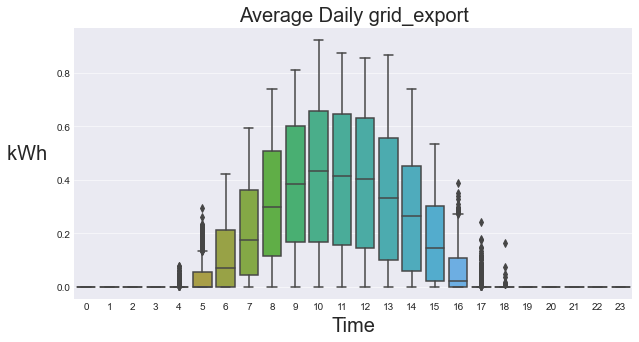

In [10]:
# Create a boxplot of the average grid_export 
plt.figure(figsize=(10,5))
sns.boxplot(HS_energy['hour'], HS_energy['grid_export'])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_axisbelow(True)
plt.gca().grid(axis='y',alpha=.7)

plt.title('Average Daily grid_export',fontsize=20)

plt.xlabel('Time', fontsize=20)

plt.ylabel("kWh ",rotation='0',ha='right', fontsize=20)
plt.show()

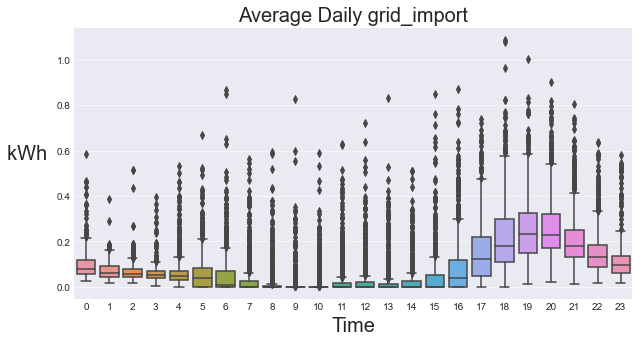

In [11]:
# Create a boxplot of the average grid_import
plt.figure(figsize=(10,5))
sns.boxplot(HS_energy['hour'], HS_energy['grid_import'])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().set_axisbelow(True)
plt.gca().grid(axis='y',alpha=.7)

plt.title('Average Daily grid_import',fontsize=20)

plt.xlabel('Time', fontsize=20)

plt.ylabel("kWh ",rotation='0',ha='right', fontsize=20)
plt.show()

<AxesSubplot:>

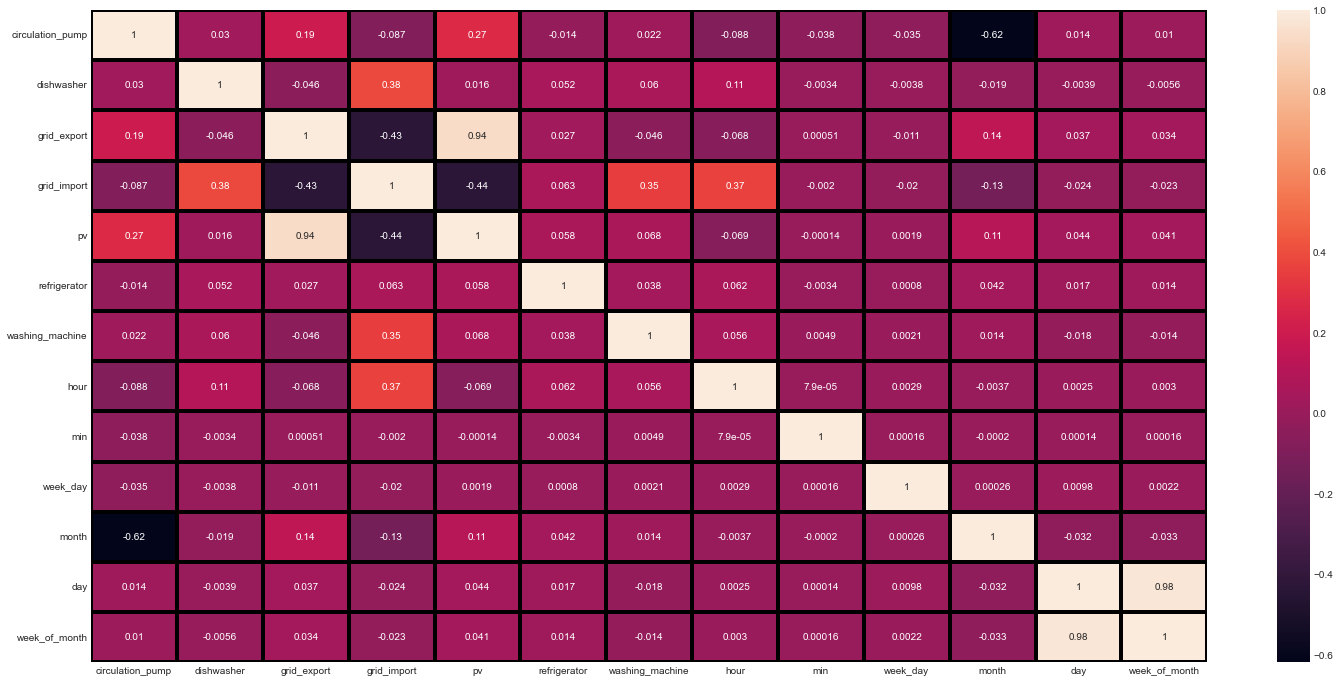

In [12]:
fig, ax = plt.subplots(figsize=(25,12))
sns.heatmap(HS_energy.corr(), annot = True, linewidths=4, linecolor='black')

<AxesSubplot:xlabel='grid_import'>

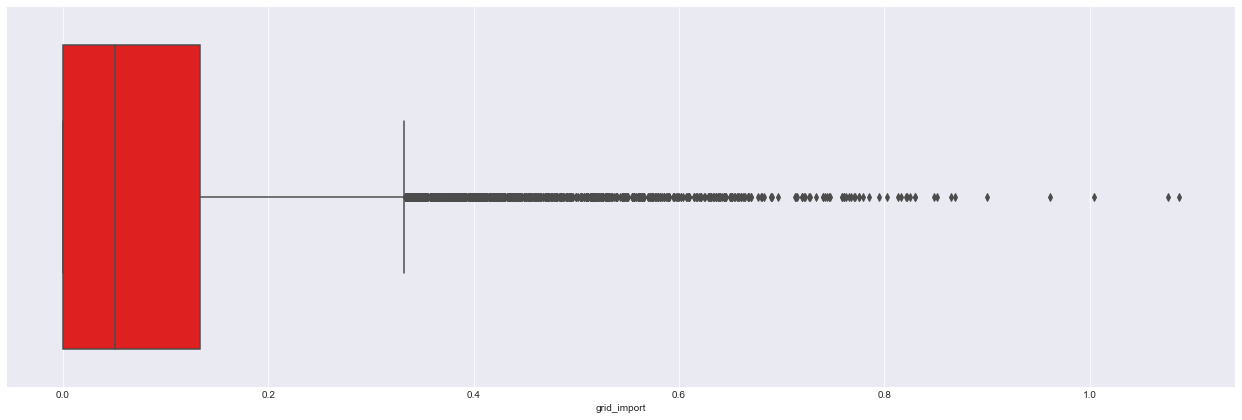

In [13]:
fig, ax = plt.subplots(figsize=(22,7))
sns.boxplot(HS_energy["grid_import"],color='red')

<AxesSubplot:xlabel='grid_export'>

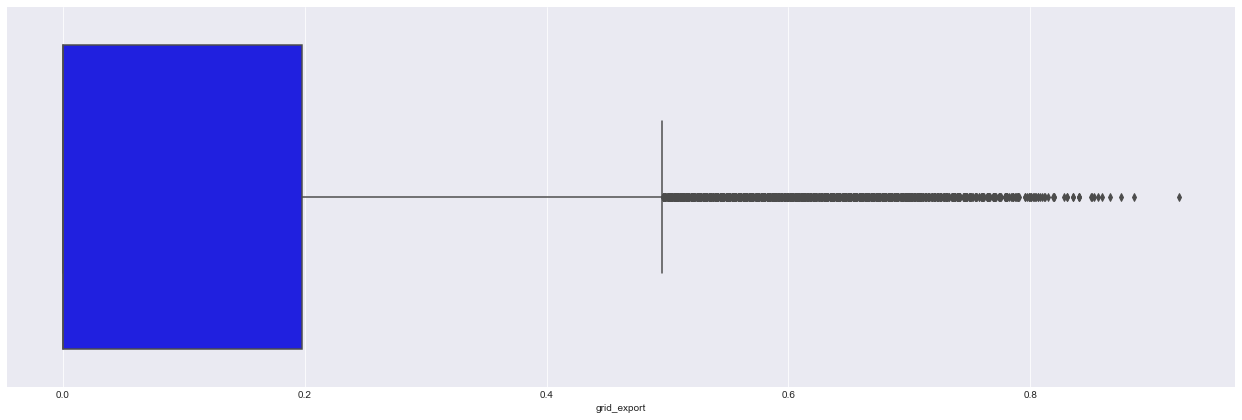

In [14]:
fig, ax = plt.subplots(figsize=(22,7))
sns.boxplot(HS_energy["grid_export"],color='blue')

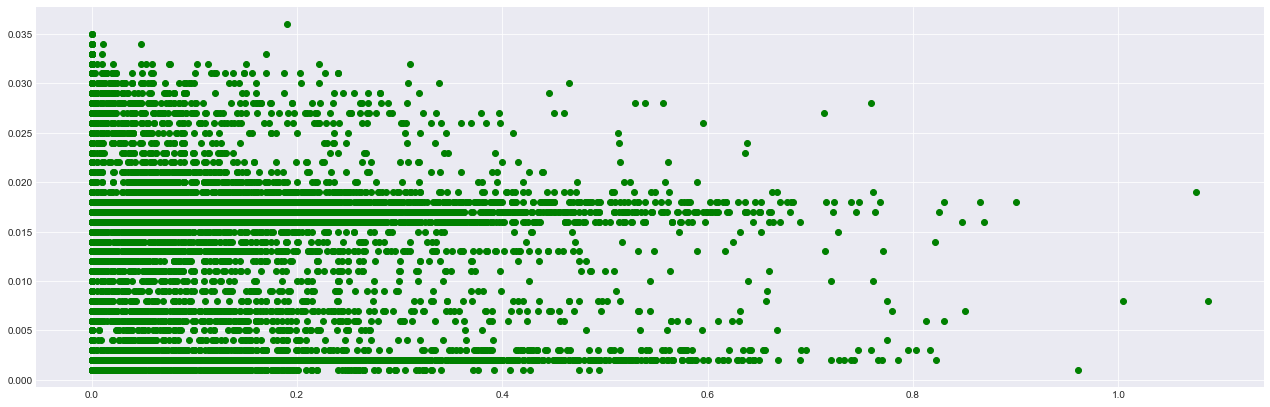

In [15]:
fig, ax = plt.subplots(figsize=(22,7))
plt.scatter(HS_energy["grid_import"],HS_energy["circulation_pump"],color='green')

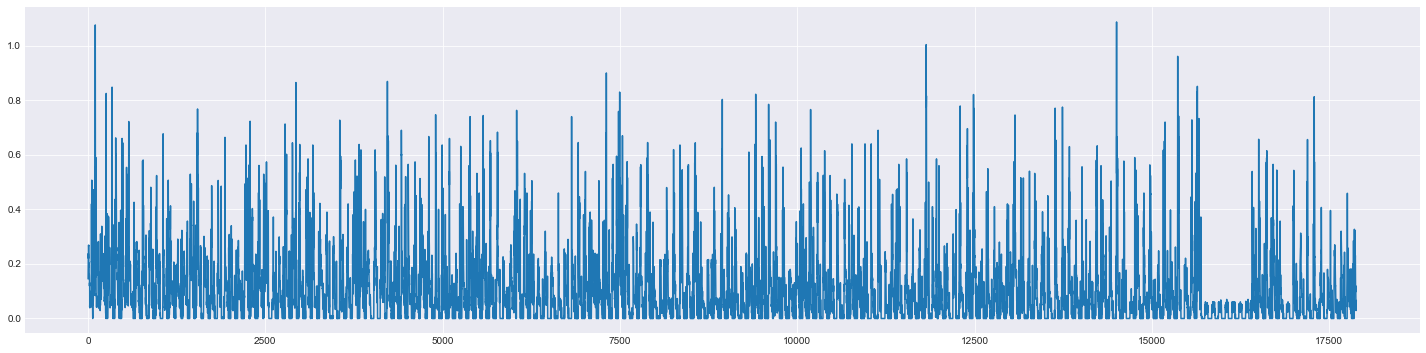

In [16]:
f,ax = plt.subplots(1, 1,figsize=(25,6))
plt.plot(HS_energy["grid_import"])

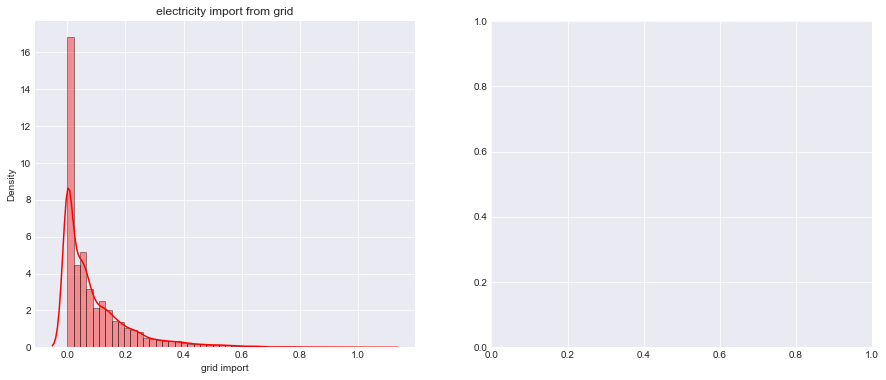

In [17]:
f,ax = plt.subplots(1, 2,figsize=(15,6))


#plotting distribution of target column grid import
sns.distplot(HS_energy.grid_import, hist=True, color = 'red',hist_kws={'edgecolor':'black'},ax=ax[0])
ax[0].set_title("electricity import from grid")
ax[0].set_xlabel('grid import')

#ploting distribution of log of target column grid import

#sns.distplot(np.log(HS_energy.grid_import), hist=True, color = 'red',hist_kws={'edgecolor':'black'},ax=ax[1])
#ax[1].set_title("Log electricity import from grid")
#ax[1].set_xlabel('grid import log')

HS_energy['log_grid import']=np.log(HS_energy['grid_import'])

In [18]:
consumption_of_different_device= ['circulation_pump','dishwasher','refrigerator','washing_machine']


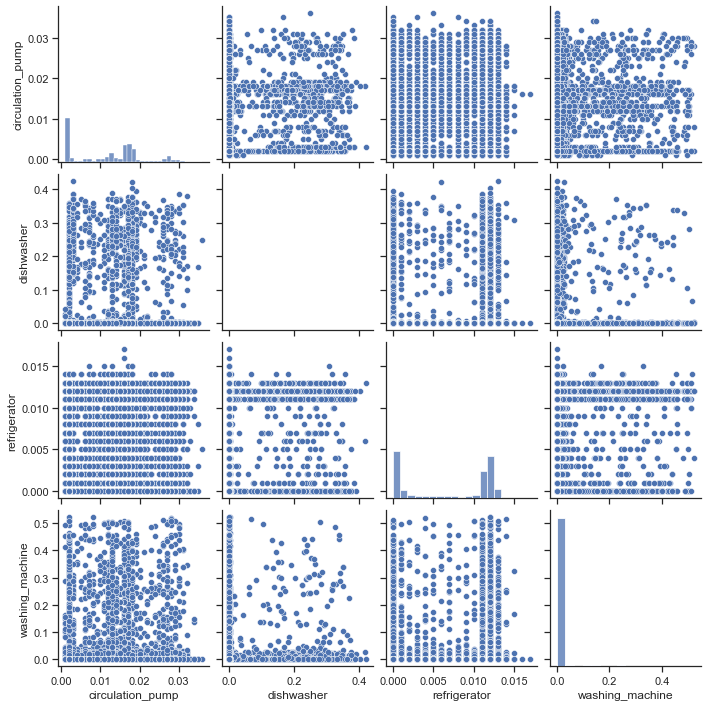

In [19]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(HS_energy[consumption_of_different_device])
plt.show()

<AxesSubplot:>

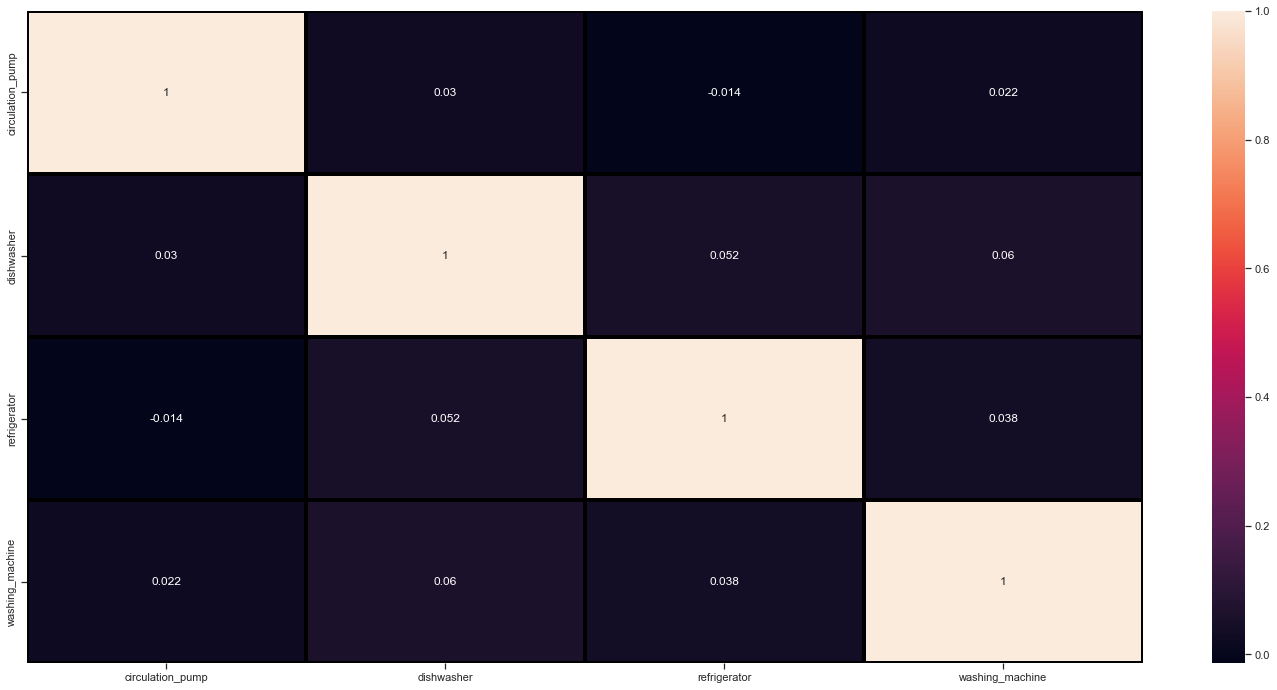

In [20]:
fig, ax = plt.subplots(figsize=(25,12))
sns.heatmap(HS_energy[consumption_of_different_device].corr(), annot = True, linewidths=4, linecolor='black')

In [21]:
cols_for_consideration = ['circulation_pump','dishwasher','refrigerator','washing_machine']

In [22]:

cols_for_consideration.append('pv')
cols_for_consideration.append('hour')
cols_for_consideration.append('week_day')

In [23]:
#FINAL SET TO INDEPENDENT LABELS
cols_for_consideration

['circulation_pump',
 'dishwasher',
 'refrigerator',
 'washing_machine',
 'pv',
 'hour',
 'week_day']

SPLITTING TEST AND TRAIN SET

In [24]:
# X AND y 
X = HS_energy[cols_for_consideration]
y= HS_energy['grid_import']

In [25]:
#splitting ang taking 70% values in train set and 30% in test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=32)

In [26]:
from sklearn.preprocessing import StandardScaler

# Normalizing of X matrices for each model to mean = 0 and standard deviation = 1

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X_train)
X = scaler.transform(X_test)

In [27]:
accuracy = []
r2_val = []
rmse_val =[]

EVALUATION METRICES

In [28]:
#function for model scored
def model_scores(model,xtest,ytest):

  #r2score
  r2 =  metrics.r2_score(ytest,model.predict(xtest))

  #root mean squared error
  rmse = sqrt(mean_squared_error(ytest,model.predict(xtest)))

  #accuracy
  acc = 100 - (100 * np.mean(abs(model.predict(xtest) - ytest)/(ytest+0.2)))
  print('\n\n\nfor' , model)
  print('\n\n\nr2 score is', r2)
  print('rmse score is', rmse)
  print('accuracy is', acc , '% \n\n\n')
  accuracy.append(acc)
  r2_val.append(r2)
  rmse_val.append(rmse)

7. MODEL FITTING
LASSO REGRESSION
RIDGE REGRESSION
K-NEAREST NEIGHBOUR
XGBOOST
SUPPORT VECTOR MACHINE
RANDOM FOREST
GRADIENT BOOSTING
CATBOOST REGRESSION

In [29]:
model_name =[]

LASSO REGRESSION

In [30]:
lasso = Lasso()
lasso.fit(X_train,y_train)
model_scores(lasso,X_test,y_test)
model_name.append('lasso')




for Lasso()



r2 score is -0.0015837971096206438
rmse score is 0.11694574860747022
accuracy is 70.32103289514109 % 






RIDGE REGRESSION

In [31]:
ridge = Ridge()
ridge.fit(X_train,y_train)
model_scores(ridge,X_test,y_test)
model_name.append('ridge')




for Ridge()



r2 score is 0.5168511038900472
rmse score is 0.08122342317973924
accuracy is 79.4946138200211 % 







SUPPORT VECTOR MACHINE

In [32]:
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
model_scores(svr,X_test,y_test)
model_name.append('svr')




for SVR()



r2 score is 0.5150945071206484
rmse score is 0.08137094225273518
accuracy is 77.48501181353375 % 





RandomForestRegression

In [33]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
model_scores(random_forest,X_test,y_test)
model_name.append('random_forest')




for RandomForestRegressor()



r2 score is 0.6669755594682998
rmse score is 0.06743398839572473
accuracy is 87.24521291874466 % 





In [34]:
#CONVERTING EVALUATION METRICES TO DATAFRAME
eval = pd.DataFrame({'model_name' : model_name,
                                'accuracy' : accuracy,
                                'r2_val' : r2_val , 
                                'rmse_val' : rmse_val})
eval

,model_name,accuracy,r2_val,rmse_val
0,lasso,70.321033,-0.001584,0.116946
1,ridge,79.494614,0.516851,0.081223
2,svr,77.485012,0.515095,0.081371
3,random_forest,87.245213,0.666976,0.067434


<AxesSubplot:title={'center':'accuracy'}, xlabel='model_name'>

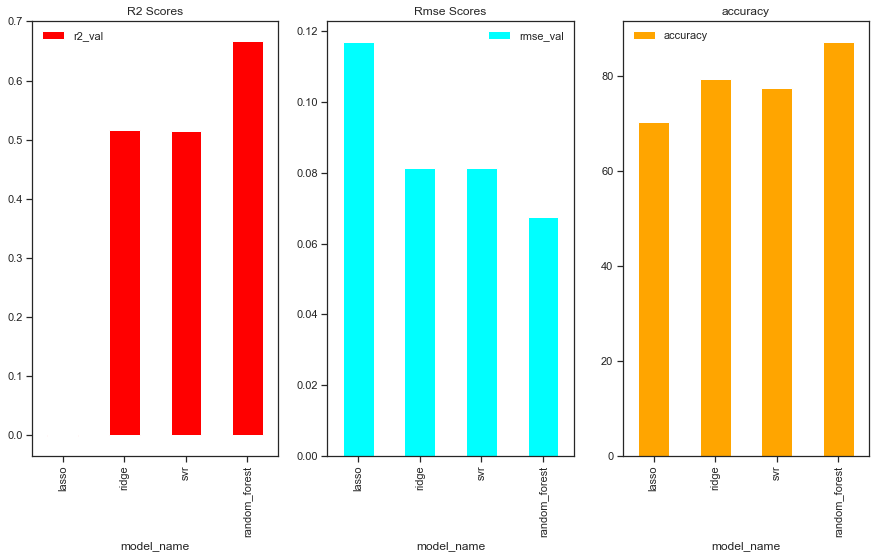

In [35]:
#PLOTTING R2 SCORES, RMSE AND ACCURACIES
fig,ax=plt.subplots(1,3, figsize=(15,8))
eval.plot(x='model_name', y='r2_val', kind="bar" , title = 'R2 Scores' ,ax=ax[0],color='red')
eval.plot(x='model_name', y='rmse_val', kind="bar" , title = 'Rmse Scores' ,ax=ax[1],color='cyan')
eval.plot(x='model_name', y='accuracy', kind="bar" , title = 'accuracy' ,ax=ax[2],color='orange')

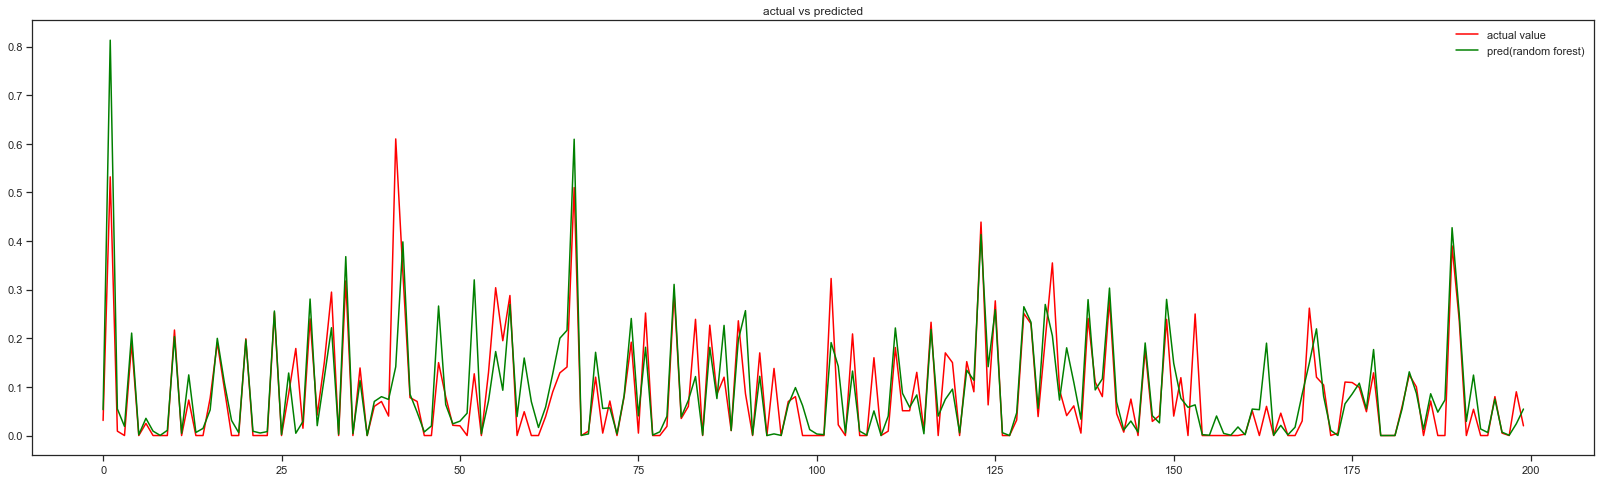

In [36]:
#PLOTTING ACTUAL LABESL AND PREDICTED ONES
fig = plt.figure(figsize=(28,8))
plt.plot(y_test[:200].values,label='actual value',color='red')
plt.plot(random_forest.predict(X_test)[:200],label='pred(random forest)', color='green')
plt.title('actual vs predicted')
plt.legend()

参数调节

In [37]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [38]:
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=66; total time=   1.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=66; total time=   1.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=66; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=133; total time=   1.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total 

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 66, 83, 100, 116,
                                                         133, 150, 166, 183,
                                                         200]},
                   random_state=42, verbose=2)

In [39]:
# R2 score on test set with tuned parameters
rf_random.score(X_test,y_test)

# RMSE score on test set with tuned parameters

rmse = np.sqrt(mean_squared_error(y_test, rf_random.predict(X_test)))
acc = 100 - (100 * np.mean(abs(rf_random.predict(X_test) - y_test)/(y_test+0.2)))
r2=metrics.r2_score(y_test,rf_random.predict(X_test))
print('\n\n\n********')
print('accuracy is',acc)
print('rmse is',rmse)
print('r2 is',r2)
print('**********\n\n\n')




********
accuracy is 87.94539302773349
rmse is 0.06362820308419014
r2 is 0.7035047564074304
**********





In [40]:
name=['random_forest','random_foresst_after_tuning']
r2s=[metrics.r2_score(y_test,random_forest.predict(X_test)) , metrics.r2_score(y_test,rf_random.predict(X_test))]
accs=[100 - (100 * np.mean(abs(random_forest.predict(X_test) - y_test)/(y_test+0.2))) , 100 - (100 * np.mean(abs(rf_random.predict(X_test) - y_test)/(y_test+0.2)))]
rms = [np.sqrt(mean_squared_error(y_test, random_forest.predict(X_test))) , np.sqrt(mean_squared_error(y_test, rf_random.predict(X_test)))]
df=pd.DataFrame({'NAME OF MODEL':name , 'R2 SCORES':r2s , 'ACCURACIES':accs , 'RMSE':rms})
df

,NAME OF MODEL,R2 SCORES,ACCURACIES,RMSE
0,random_forest,0.666976,87.245213,0.067434
1,random_foresst_after_tuning,0.703505,87.945393,0.063628



AFTER HYPERMATER TUNING RANDOM FOREST GAVE BETTER RESULTS